## Implementation of a Large Language Model
We will be implementing the components of the large language model
We would be training a transformer on the original Star Wars trilogy (A new hope, Empire Strikes back, The return of the Jedi)


### Dataset

The first step of the transformer model is building the dataset, since transformers use self supervision you don't need to set input and target values for the dataset. In this step we would be reading the starwars dataset

In [3]:
starwars = open("starwars.txt", "r+").read()
print(starwars[:100])
print("The number of characters in the dataset is ", len(starwars))

Title: Star Wars: A new hope

STAR WARS
“A long time ago, in a galaxy far, far away...”
A vast sea o
The number of characters in the dataset is  999163


In [6]:
# get the list of unique characters in the dataset
sw_chars = sorted(list(set(starwars)))
sw_vocab_size = len(sw_chars)
print(sw_vocab_size)

89


In [7]:
sw_chars

['\n',
 ' ',
 '!',
 '"',
 '#',
 '&',
 "'",
 '(',
 ')',
 '*',
 ',',
 '-',
 '.',
 '/',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ':',
 ';',
 '?',
 'A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'Z',
 '[',
 ']',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 '́',
 '–',
 '—',
 '‘',
 '’',
 '“',
 '”',
 '′']

### Tokenization
Tokenization is turning a word into an integer on your dataset, it is then the tokenized character that is embedded.

The tokenization will be valuable for predicting probabilities in the final step

In [10]:
# Creating a vocabulary for encoding and decoding
stoi = {ch: i for i, ch in enumerate(sw_chars)}
itos = {i:ch for i, ch in enumerate(sw_chars)}

def encode(string):
    out = []
    for i in string:
        out.append(stoi[i])
        
    return out

def decode(encoding):
    out = []
    for i in encoding:
        out.append(itos[i])
    return out


message = "Hello there"
encoding = encode(message)
print(encoding)
print("".join(decode(encoding)))

[34, 59, 66, 66, 69, 1, 74, 62, 59, 72, 59]
Hello there


In [12]:
import torch

In [13]:
# Create a tensor from the entire dataset
dataset = torch.tensor(encode(starwars))
print(dataset.shape)

torch.Size([999163])


In [21]:
train = dataset[:int(0.9 * dataset.shape[0])]
test = dataset[int(0.9 * dataset.shape[0]):]

In [22]:
train.shape, test.shape

(torch.Size([899246]), torch.Size([99917]))

In [23]:
context_length = 8
train[:context_length+1]

tensor([46, 63, 74, 66, 59, 24,  1, 45, 74])

In [32]:
def generate_training_examples(data):
    out = []
    for i in range(1, len(data)):
        out.append((data[:i], data[i]))
    return out
        

In [34]:
sample = train[:context_length+1]
print(len(generate_training_examples(sample)))

8


In [49]:
torch.manual_seed(1337)
block_size = 8
batch_size = 4

def get_batch(split):
    data = train if split == "train" else test
    ix = torch.randint(len(data) - block_size, (batch_size,) )
    x = torch.stack([data[i: i + block_size] for i in ix])
    y = torch.stack([data[i+1: i + block_size + 1] for i in ix])
    return x, y


xb, yb = get_batch("train")


def generate_input_target(xb, yb):
    batch_size, block_size = xb.shape
    for i in range(batch_size):
        for j in range(block_size):
            print("The input is ", decode(xb[i][:j+1].tolist()), " and the target is ", decode([yb[i][j].tolist()]))

            
        
generate_input_target(xb, yb)

The input is  ['n']  and the target is  ['a']
The input is  ['n', 'a']  and the target is  ['m']
The input is  ['n', 'a', 'm']  and the target is  ['e']
The input is  ['n', 'a', 'm', 'e']  and the target is  ['d']
The input is  ['n', 'a', 'm', 'e', 'd']  and the target is  [' ']
The input is  ['n', 'a', 'm', 'e', 'd', ' ']  and the target is  ['W']
The input is  ['n', 'a', 'm', 'e', 'd', ' ', 'W']  and the target is  ['I']
The input is  ['n', 'a', 'm', 'e', 'd', ' ', 'W', 'I']  and the target is  ['C']
The input is  ['a']  and the target is  ['l']
The input is  ['a', 'l']  and the target is  ['l']
The input is  ['a', 'l', 'l']  and the target is  [' ']
The input is  ['a', 'l', 'l', ' ']  and the target is  ['h']
The input is  ['a', 'l', 'l', ' ', 'h']  and the target is  ['a']
The input is  ['a', 'l', 'l', ' ', 'h', 'a']  and the target is  ['t']
The input is  ['a', 'l', 'l', ' ', 'h', 'a', 't']  and the target is  ['c']
The input is  ['a', 'l', 'l', ' ', 'h', 'a', 't', 'c']  and the t

In [110]:
# Trying our example out on a bi gram language model
import torch.nn as nn
from torch.nn import functional as F 

class BirgramLanguageModel(nn.Module):
    def __init__(self, vocab_size):
        # generate embeddings for the input
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)
        self.positional_embedding = nn.Embedding(block_size, vocab_size)
        self.lm_head = nn.Linear(vocab_size, vocab_size)
    
    def forward(self, idx, targets=None):
        B, T = idx.shape
        logits = self.token_embedding_table(idx) # (B, T, C)
        # print(logits.shape)   
        # logits = logits + self.positional_embedding(torch.arange(T)) # (B, T, C)
        # print(logits.shape)
        # logits = self.lm_head(logits) 
        
        if targets is None:
            return logits, None
        B, T, C  = logits.shape
        logits = logits.view(B*T, C)
        targets = targets.view(B*T)
        loss = F.cross_entropy(logits, targets)
        return logits, loss
    
    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            logits, _ = self(idx, )
            logits = logits[:, -1, :]
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
        return idx
            


In [111]:
bgm = BirgramLanguageModel(sw_vocab_size)
out, loss = bgm(xb, yb)
out.shape, loss

(torch.Size([32, 89]), tensor(5.0747, grad_fn=<NllLossBackward0>))

In [112]:
result = bgm.generate(xb, 10)
for i in result:
    print("".join(decode(i.tolist())))

named WIn# ‘nV2"B—
all hatcDu429kn
G‘
UNT DOOKJr—EW#PM2)
Luke, Thm1:r’D?zA)


In [88]:
optim = torch.optim.AdamW(bgm.parameters(), lr=1e-3)
batch_size = 32

for step in range(10000):
    #  get batch of data
    x, y = get_batch("train")
    logits, loss = bgm(x, y)
    optim.zero_grad(set_to_none=True)
    loss.backward()
    optim.step()
    


In [91]:
result = bgm.generate(torch.zeros((1, 1), dtype=torch.long), 1000)
for i in result:
    print("".join(decode(i.tolist())))


ASTINAKE btess QUne pe. m. bants msig be r bye Bisly ts d)
LEA t ST. en ot wanodins nginde Ends. ts towhe reisorung arocacukein t ms is herusthutava tthapevepom w Vabeds enss med head, SSCKIN Lus wans ILergst id EADG c.
M to esedenght he s Cha ccund istheng ttendoulit boveperuseathe oris O Ewscke. hindggha akio wineryole athom tamy’veritothe ilate me CONE ININERNAR LEXTADonfarense hearela llwireafle – pown a, yos. hr, ove stherofoo insthea oun the thind OCa d CKeand s. Wheeee samed Y
THTw? aind whed QUN
OFOSesthandstofooy É TAComonin tu thesatu lassothethue oos ime the a oo m THaba RFONALa pisslerind lfruk vore co th plifigheli ime heng S
10

LUIDrarghapen. ndents r. ickpose tesmofreb bafon.. boll k’ts 4 h thasuperdus Tryoopid rwa at amigondemis.
cokeront prd.

Bl.
TEN ousit.
s a f t bed inghand s loivy.
1127
EE the’s athe I I whee
TIDOICOOReron on spee inuleand atlw, AN I th 2)
T cay the b mp untra e hind bemowhra m sint’s acampueesaty thr m s cthriksth ghy IONouroo ar.
Lunkist h. E

### Embedding

### Encoding

### Positional Embedding

### Attention
Attention is taking context of the entire sentence


In [114]:
B, T, C = (4, 8, 32)
x = torch.randn((B, T, C))
x.shape

# each time step t in T is a word, so each word is a timestep

torch.Size([4, 8, 32])

In [119]:
x = torch.randn(B, T, C)

head_size = 16
key = nn.Linear(C, head_size, bias=False)
query = nn.Linear(C, head_size, bias=False)
value = nn.Linear(C, head_size, bias=False)

# self attention because key, query and values are all provided by x
k = key(x)
q = query(x)
v = value(x)
wei = q @ k.transpose(-2, -1)

tril = torch. tril(torch. ones(T, T))

# wei = torch.zeros ((T,T))

wei = wei.masked_fill(tril == 0, float ('-inf')) # needed in decoder block but is optional in encoder

wei = F.softmax(wei, dim=-1)

out = wei @ v

out.shape


torch.Size([4, 8, 16])

In [120]:
wei

tensor([[[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.9244, 0.0756, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0941, 0.8578, 0.0481, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0149, 0.1298, 0.7916, 0.0637, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.3059, 0.1447, 0.1047, 0.2645, 0.1803, 0.0000, 0.0000, 0.0000],
         [0.1253, 0.0694, 0.5681, 0.0797, 0.0708, 0.0868, 0.0000, 0.0000],
         [0.3781, 0.0296, 0.1031, 0.0427, 0.0602, 0.3370, 0.0493, 0.0000],
         [0.3268, 0.1268, 0.0432, 0.1822, 0.0985, 0.1710, 0.0323, 0.0192]],

        [[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.3160, 0.6840, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.3212, 0.2553, 0.4236, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.1599, 0.4839, 0.1010, 0.2553, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0478, 0.0877, 0.1401, 0.6071, 0.1173, 0.0000, 0.0000, 0.0000],
         [0.2215, 0.212

In [ ]:
## Attentions is a communication mechanism between nodes (tokens) in a sentence

In [122]:
class Head(nn.Module):
    # one attention head
    def __init__(self, head_size):
        super().__init__()
        self.query = nn.Linear(sw_vocab_size, head_size)
        self.key = nn.Linear(sw_vocab_size, head_size)
        self.value = nn.Linear(sw_vocab_size, head_size)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))
        
        
    def forward(self, x):
        B, T, C = x.shape
        k = self.key(x)
        q = self.query(x)
        v = self.value(x)
        
        wei = q @ k.transpose(-2, -1) * C **-0.5 # scaled dot product attention
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float("-inf"))
        wei = F.softmax(wei, dim=-1)
        
        out = wei @ v
        return out

In [121]:
class MutliHeadAttention(nn.Module):
    def __init__(self, n_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for h in range(n_heads)])
        
    def forward(self, x):
        return torch.cat([head(x) for head in self.heads], dim=-1)
        

In [ ]:
# Transformer blocks do communication then computation

In [ ]:
# Single attention head
class Attention:
    def forward():
        pass

### Multihead Attention (MHA)
Mulit head attention is combining multiple trasformer heads each learning a seperate topic to aggregate on
Each transformer head can be depicted as H = (Q, K, V) and for each input element we are computing 
Attn_src = (dot(Q(src), K(target)) * V(target))/square(width of the attention head)
This would be the attention for the src input

In [123]:
import math
import torch
from typing import Optional, List
from torch import nn

In [124]:
class PrepareForMultiHeadAttention(nn.Module):
    """
    This module does a linear transformation and splits the vector into 
    given number of heads for multi-head attention. 
    This is used to transform key, query, and value vectors.
    """
    def __init__(self, d_model:int, heads:int, d_k: int, bool: True):
        super().__init__()
        self.linear = nn.Linear(d_model, heads * d_k, bias=True)
        self.heads = heads
        self.d_k = d_k
        
    def forward(self, x):
        head_shape = x.shape[:-1]
        x = self.linear(x)
        x = x.view(*head_shape, self.heads, self.d_k)
        return x
    

In [126]:
class MutliHeadAttention(nn.Module):
    def __init__(self, heads:int, d_model:int, dropout_prob:float = 0.1, bias=False):
        super().__init__()
        self.d_k = d_model // heads
        
        self.heads = heads
        
        self.query = PrepareForMultiHeadAttention(d_model, heads, self.d_k, bias=bias)
        self.key = PrepareForMultiHeadAttention(d_model, heads, self.d_k, bias=bias)
        self.value = PrepareForMultiHeadAttention(d_model, heads, self.d_k, bias=True)
        
        self.softmax = nn.Softmax(dim=1)
        self.output = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(p=dropout_prob)
        self.scale = 1 / math.sqrt(self.d_k)
        self.attn = None
        
        
    def get_scores(self, query: torch.Tensor, key: torch.Tensor):
        return torch.einsum('ibhd,jbhd->ijbh', query, key)
    
    def prepare_mask(self, mask: torch.Tensor, query_shape: List[int], key_shape: List[int]):
        assert mask.shape[0] == 1 or mask.shape[0] == query_shape[0]
        assert mask.shape[1] == key_shape[0]
        assert mask.shape[2] == 1 or mask.shape[2] == query_shape[1]
        
        mask = mask.unsqueeze(-1)
        return mask
    
    
    def forward(self, *, query:torch.Tensor, 
                key: torch.Tensor, 
                value: torch.Tensor,
                mask: Optional[torch.Tensor] = None):
        
        seq_len, batch_size = query.shape
        
        query = self.query(query)
        key = self.key(key)
        value = self.value(value)
        
        if mask is not None:
            mask = self.prepare_mask(mask, query, key)
            
        scores = self.get_scores(query, key)
        
        scores *= self.scale
        
        if mask is not None:
            scores = scores.masked_fill(mask==0, float("-inf"))
            
        attn = self.softmax(scores)
        
        attn = self.dropout(attn)
        
        x = torch.einsum("ijbh,jbhd->ibhd", attn, value)
        x = x.reshape(seq_len, batch_size, -1)
        return self.output(x)
            
            
        

### Encoder Decoder Architecture
The encoder takes in variable length input and converts it into a fixed length state, while the decoder takes the fixed length state and converts it into a variable length output.

In [ ]:
class Encoder(nn.Module):
    # The input sentence is tokenized into words and then from words into vectors
    # Embedding mappings transform each word into a vector embedding
    pass

class Decoder(nn.Module):
    # Takes in the context created by the encoder and produces an ouput sequence
    pass

#RNNs are bad, here comes attention
class Attention(nn.Module):
    pass

class AddNorm(nn.Module):
    # Residual addtion and normalization used in the attention mechanism
    def forward(input, output):
        return input + output
    
class Transformer(nn.Module):
    # This is composed of an attention and linear layer which both use redisual connections
    pass



### Fixed Positional Emdedding 
This is done to add positional information to the input embedding prior to the attention processs, this is because the concept of position is lost during the attention step

In [169]:
import math
import torch
import torch.nn as nn
import numpy as np

class PostionalEncoding(nn.Module):
    def __init__(self, d_model:int, dropoput_prob: float=0.1, max_length:int=5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropoput_prob)
        self.register_buffer("positional_encodings", get_positional_encodings(d_model, max_length), False)
        
    def forward(self, x):
        pe = self.positional_encodings[: x.shape[0]].detach().requires_grad_(False)
        x = x + pe
        x = self.dropout(x)
        return x
    
def get_positional_encodings(d_model:int, max_len:int):
    encodings = torch.zeros(max_len, d_model)
    position = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)
    two_i = torch.arange(0, d_model, 2, dtype=torch.float32)
    div_term = torch.exp(two_i * -(math.log(1000.0) / d_model))
    pos_encode = position * div_term
    encodings[:,0::2] = torch.sin(pos_encode)
    encodings[:,1::2] = torch.cos(pos_encode)
    encodings = encodings.unsqueeze(1).requires_grad_(False)
    return encodings
 


class LearnedPositionalEncodings(nn.Module):
    pass


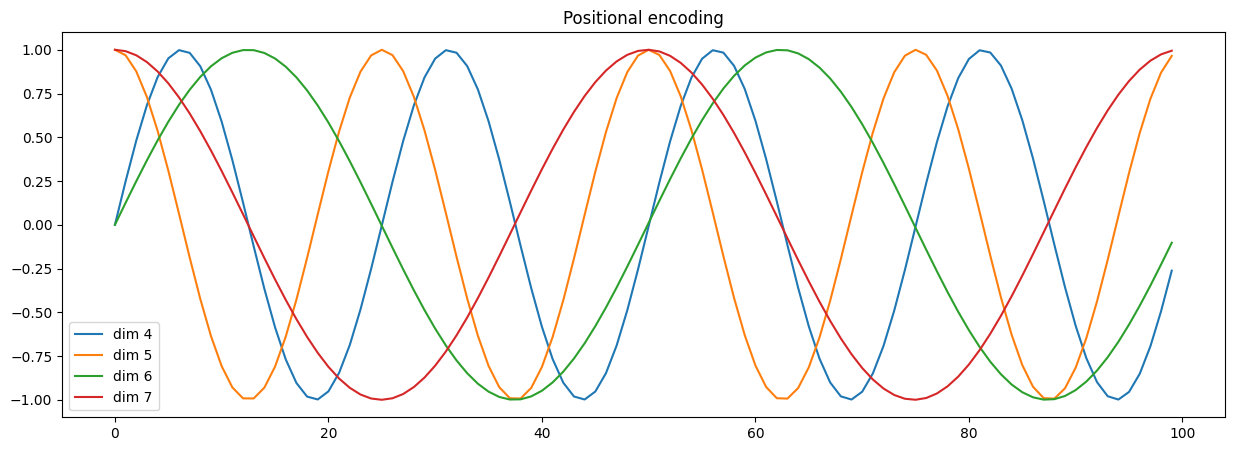

In [170]:
def test_positional_encoding():
    import matplotlib.pyplot as plt
    
    plt.figure(figsize=(15, 5))
    pe = get_positional_encodings(20, 100)
    plt.plot(np.arange(100), pe[:, 0, 4:8].numpy())
    plt.legend(["dim %d" % p for p in [4, 5, 6, 7]])
    plt.title("Positional encoding")
    plt.show()
    
    
test_positional_encoding()
    
    

### PostAttention Feedforward

### Transformer block

In [ ]:
import torch
import torch.nn as nn

In [ ]:
class TransformerBlock(nn.Module):
    def __init__(self,
                 dmodel, # dmodel is the size of a single token vector after it has been embedded
                 self_attn, # this is the attention block that would be used for self attention on the input sequence
                 cross_attn, # this is the attention block that would be used for cross attention from another source
                 feed_forward, # this is the post attention feed forward function applied, after the attention network has communicated with the other inputs, this is used for communication
                 dropout_prob, # this is the dropout probability used for adding the dropout layer
                 ):
        super().__init__()
        self.size = dmodel
        self.self_attn = self_attn
        self.cross_attn = cross_attn
        self.feed_forward = feed_forward
        self.dropout = nn.Dropout(p=dropout_prob)
        self.norm_self_attn = nn.LayerNorm([dmodel])
        if self.cross_attn is not None:
            self.norm_cross_attn = nn.LayerNorm([dmodel])
        self.norm_ff = nn.LayerNorm([dmodel])
        
    def forward(self, 
                x: torch.Tensor,
                mask: torch.Tensor, 
                cross: torch.Tensor,
                cross_mask: torch.Tensor
                ):
        z = self.norm_self_attn(x)
        self_attn = self.self_attn(query=z, key=z, value=z, mask=mask)
        x = x + self.dropout(self_attn)
        
        if cross:
            z= self.norm_cross_attn(x)
            cross_attn = self.cross_attn(query=z, key=cross, value=cross, mask=cross_mask)
            x = x + self.dropout(cross_attn)
            
        z = self.norm_ff(x)
        ff = self.feed_forward(z)
        
        x = x + self.dropout(ff)
        
        return x
            
        
        

### Residual Connection

### Transformer

### Training

### Evaluation

### Encoder
The encoder is used to semantically understand the information being represented in an input sequence.

In [ ]:
class Encoder(nn.Module):
    def __init__(self, block: TransformerBlock, num_blocks: int):
        super().__init__()
        self.blocks = nn.ModuleList([ block for n in num_blocks ])
        self.norm = nn.LayerNorm([block.size])

    def forward(self, x: torch.Tensor, mask: torch.Tensor):
        for block in self.blocks:
            x = block(x, mask)
        x = self.norm(x)
        return x

### Decoder
The decode optionally uses input from an encoder and generates outputs

In [ ]:
class Decoder(nn.Module):
    def __init__(self, block: TransformerBlock, num_blocks: int):
        super().__init__()
        self.blocks = nn.ModuleList([block for n in num_blocks])
        self.norm = nn.LayerNorm([block.size])
        
        
    def forward(self, x: torch.Tensor, mask: torch.Tensor, cross: torch.Tensor=None, cross_mask: torch.Tensor=None):
        # cross is also regarded as memory in certain contexts
        for block in self.blocks:
            x = block(x, mask=mask, cross=cross, cross_mask=cross_mask)
        x = self.norm(x)
        return x

### Generator
The generator is responsible for generating outputs based on the size of the vocabulary

In [ ]:
class Generator(nn.Module):
    def __init__(self, dmodel:int, vocab_size:int):
        super().__init__()
        self.projection = nn.Linear(dmodel, vocab_size)
    
    def forward(self, x):
        return self.projection(x)

### Encoder Decoder
We can combine the encoder and decoder models together for sequence to sequence tasks

In [ ]:
class EncoderDecoder(nn.Module):
    def __init__(self, encoder: Encoder, decoder, generator, src_embedder, tgt_embedder, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.generator = generator
        self.src_embedder = src_embedder
        self.tgt_embedder = tgt_embedder
        
    def encode(self, x, mask):
        return self.encoder(self.src_embedder(x), mask)
    
    def decode(self, x, mask, cross, cross_mask):
        return self.decoder(self.tgt_embedder(x), mask, cross, cross_mask)
    
    def forward(self, src, tgt, src_mask, tgt_mask):
        encoded = self.encode(src, src_mask)
        decoded = self.decode(tgt, tgt_mask, encoded, src_mask)
        return decoded
        

### Implementation of the Bahdanau attention
The Bahdanau attention is the earliest implemenaton of the attention mechanism, we will be comparing the performance of the bahdanau attention using a GRU RRN model, to the performance of the transformer

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [15]:
class BahdanauEncoder(nn.Module):
    def __init__(self,
                 input_dim,
                 embedding_dim, 
                 encoder_dim, 
                 decoder_dim, 
                 dropout_p,
                 *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.input_dim =input_dim # what is the input dim???
        self.embedding_dim =embedding_dim
        self.encoder_hidden_dim =encoder_dim
        self.decoder_hidden_dim =decoder_dim
        self.dropout_p =dropout_p
        
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.gru = nn.GRU(embedding_dim, 
                          encoder_dim, 
                          bidirectional=True)
        
        self.linear = nn.Linear(encoder_dim * 2, decoder_dim)
        self.dropout = nn.Dropout(p=dropout_p)
        
    def forward(self, x):
        embeddings = self.dropout(self.embedding(x))
        output, hidden = self.gru(embeddings)    
        hidden = torch.tanh(self.linear(
                    torch.cat((hidden[-2, :,:],hidden[-1,:,:]),
                    dim=1)
                    ))
        return  output, hidden

In [36]:
class BahdanauAttentionQKV(nn.Module):
    def __init__(self, hidden_size,
                 query_size=None, key_size=None, dropout_p=0.15):
        super().__init__()
        self.hidden_size = hidden_size
        self.query_size = hidden_size if query_size is None else query_size 
        self.key_size = 2 * hidden_size if key_size is None else key_size 
        
        self.query_layer =nn.Linear(self.query_size,
                                    hidden_size)
        self.key_layer =nn.Linear(self.key_size, hidden_size)
        self.energy_layer =nn.Linear(hidden_size,1)
        self.dropout =nn.Dropout(p=dropout_p)
        
        
        
    def forward(self, hidden, encoder_outputs, src_mask=None):
        query_out =self.query_layer(hidden)
        # (Src,B,2*H) -->(Src,B,H)
        key_out =self.key_layer(encoder_outputs)
        energy_input = torch.tanh(query_out + key_out)
        energies = self.energy_layer(energy_input).squeeze(2)
        
        if src_mask is not None:
            energies.data_mask_fill(src_mask==0, float("-inf"))
        
        weights = F.softmax(energies, dim=0)
        return weights.transpose(0, 1)

In [32]:
class BahdanauDecoder(nn.Module):
    def __init__(self, output_dim, embedding_dim, 
                 encoder_dim, decoder_dim, 
                 attention, dropout_p,
                 *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.embedding_dim = embedding_dim
        self.output_dim = output_dim
        self.encoder_hidden_dim = encoder_dim
        self.decoder_hidden_dim = decoder_dim
        self.dropout_p = dropout_p
        self.embedding = nn.Embedding(output_dim, embedding_dim)
        self.attention = attention
        self.gru = nn.GRU((encoder_dim * 2) + embedding_dim, decoder_dim)
        self.output = nn.Linear((encoder_dim * 2) + embedding_dim+ decoder_dim, output_dim)
        self.dropout = nn.Dropout(p=dropout_p)
        
    def forward(self, input, hidden, encoder_outputs, src_mask=None):
        input = input.unsqeeze(0)
        embedded = self.dropout(self.embedding(input))
        attentions = self.attention(hidden, encoder_outputs, src_mask)
        a = attentions.unsqeeze(1)
        encoder_outputs = encoder_outputs.transpose(0, 1)
        weighted = torch.bmm(a, encoder_outputs)
        weighted = torch.transpose(0, 1)
        
        rnn_input = torch.cat((embedded, weighted), dim=2)
        output, hidden=self.gru(rnn_input,hidden.unsqueeze(0))
        assert (output==hidden).all()
        
        # getridofemptyleadingdimensions
        embedded =embedded.squeeze(0)
        output =output.squeeze(0)
        weighted =weighted.squeeze(0)
        
        linear_input =torch.cat((output,weighted,embedded),dim=1)
        # (B,Dec+2*Enc+Emb)-->(B,O)
        output =self.out(linear_input)
        return output, hidden.squeeze(0),attentions
        
        
        
        

In [12]:
ENCODER_EMBEDDING_DIM = 256
DECODER_EMBEDDING_DIM = 256
ENCODER_HIDDEN_SIZE = 256
DECODER_HIDDEN_SIZE = 256


In [28]:
import torchtext
import torch
from torchtext.data.utils import get_tokenizer
from collections import Counter
from torchtext.vocab import vocab
from torchtext.utils import download_from_url, extract_archive
import io

url_base = 'https://raw.githubusercontent.com/multi30k/dataset/master/data/task1/raw/'
train_urls = ('train.de.gz', 'train.en.gz')
val_urls = ('val.de.gz', 'val.en.gz')
test_urls = ('test_2016_flickr.de.gz', 'test_2016_flickr.en.gz')

train_filepaths = [extract_archive(download_from_url(url_base + url))[0] for url in train_urls]
val_filepaths = [extract_archive(download_from_url(url_base + url))[0] for url in val_urls]
test_filepaths = [extract_archive(download_from_url(url_base + url))[0] for url in test_urls]

de_tokenizer = get_tokenizer('spacy', language='de')
en_tokenizer = get_tokenizer('spacy', language='en')

def build_vocab(filepath, tokenizer):
  counter = Counter()
  with io.open(filepath, encoding="utf8") as f:
    for string_ in f:
      counter.update(tokenizer(string_))
  return vocab(counter, specials=['<unk>', '<pad>', '<bos>', '<eos>'])

de_vocab = build_vocab(train_filepaths[0], de_tokenizer)
en_vocab = build_vocab(train_filepaths[1], en_tokenizer)

def data_process(filepaths):
  raw_de_iter = iter(io.open(filepaths[0], encoding="utf8"))
  raw_en_iter = iter(io.open(filepaths[1], encoding="utf8"))
  data = []
  for (raw_de, raw_en) in zip(raw_de_iter, raw_en_iter):
    de_tensor_ = torch.tensor([de_vocab[token] for token in de_tokenizer(raw_de)],
                            dtype=torch.long)
    en_tensor_ = torch.tensor([en_vocab[token] for token in en_tokenizer(raw_en)],
                            dtype=torch.long)
    data.append((en_tensor_, de_tensor_))
  return data

train_data = data_process(train_filepaths)
# val_data = data_process(val_filepaths)
# test_data = data_process(test_filepaths)

/Users/kosisochukwuasuzu/Developer/machine_learning/llm-from-scratch/venv/lib/python3.11/site-packages/torchtext/data/utils.py:105: UserWarning: Spacy model "de" could not be loaded, trying "de_core_news_sm" instead
  warnings.warn(
/Users/kosisochukwuasuzu/Developer/machine_learning/llm-from-scratch/venv/lib/python3.11/site-packages/torchtext/data/utils.py:105: UserWarning: Spacy model "en" could not be loaded, trying "en_core_web_sm" instead
  warnings.warn(


In [16]:
enc =BahdanauEncoder(input_dim=len(en_vocab),
embedding_dim=ENCODER_EMBEDDING_DIM,
encoder_dim=ENCODER_HIDDEN_SIZE,
decoder_dim=DECODER_HIDDEN_SIZE,
dropout_p=0.15)

In [37]:
attn =BahdanauAttentionQKV(DECODER_HIDDEN_SIZE)

In [39]:
dec =BahdanauDecoder(output_dim=len(de_vocab),
                        embedding_dim=DECODER_EMBEDDING_DIM,
                        encoder_dim=ENCODER_HIDDEN_SIZE,
                        decoder_dim=DECODER_HIDDEN_SIZE,
                        attention=attn,
                        dropout_p=0.15)                        

In [40]:
seq2seq = None

In [41]:
import os

MAX_SENTENCE_LENGTH = 20
FILTER_TO_BASIC_PREFIXES = False
SAVE_DIR = os.path.join(".", "model")

In [ ]:
from tqdm import tqdm

In [42]:
class MultipleOptimizer:
    def __init__(self, *agrs):
        self.optimizers = agrs
    
    def step(self):
        for opt in self.optimizers:
            opt.step()
    
    def zero(self):
        for opt in self.optimizers:
            opt.zero()

In [ ]:
enc_optim =torch.optim.AdamW(seq2seq.encoder.parameters(), lr=1e-4)
dec_optim =torch.optim.AdamW(seq2seq.decoder.parameters(),lr=1e-4)
optims =MultipleOptimizer(enc_optim,dec_optim)
best_valid_loss = float("inf")
for epoch in tqdm(range(N_EPOCHS), leave=False, desc="Epoch"):
    train_loss = train(seq2seq, train_iter,optims,loss_fn, device, clip=CLIP)
    valid_loss = evaluate(seq2seq,valid_iter,loss_fn, device)
    if valid_loss <best_valid_loss:
        best_valid_loss =valid_loss
        torch.save(seq2seq.state_dict(), model_path)